# MPS using the deesse wrapper - simulations using multiple TIs

## Import what is required

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# import from package 'geone'
from geone import img
import geone.imgplot as imgplt
import geone.customcolors as ccol
import geone.deesseinterface as dsi

## Training images (TIs)
The training images are read from the files `ti.gslib` and `ti4.gslib`. Both images have *one* variable of the same nature, but depicting different kinds of patterns.

**Note:** to clarify the terminology, we say that we work with *two* TIs having *one* variable (or property) of the same nature.

In [2]:
tiA = img.readImageGslib('ti.gslib')
tiB = img.readImageGslib('ti4.gslib')

Plot both images (using the function `imgplt.drawImage2D`).

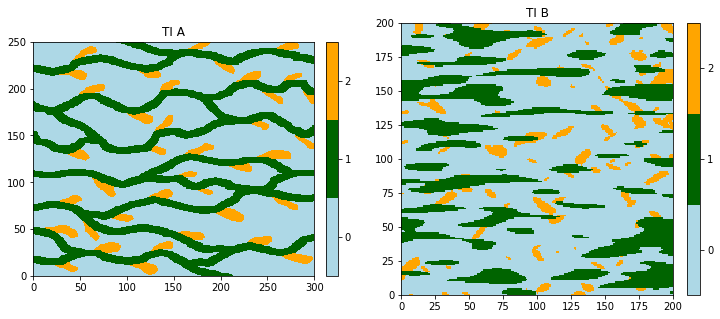

In [3]:
col = ['lightblue', 'darkgreen', 'orange']

plt.subplots(1,2, figsize=(12,5))

plt.subplot(1,2,1)
imgplt.drawImage2D(tiA, categ=True, categCol=col, title='TI A')

plt.subplot(1,2,2)
imgplt.drawImage2D(tiB, categ=True, categCol=col, title='TI B')

## Simulation grid
Define the simulation grid (number of cells in each direction, cell unit, origin).

In [4]:
nx, ny, nz = 480, 180, 1    # number of cells
sx, sy, sz = 1.0, 1.0, 1.0  # cell unit
ox, oy, oz = 0.0, 0.0, 0.0  # origin (corner of the "first" grid cell)

## Probability of TI selection
To perform a deesse simulation with multiple TIs, one needs to give for each simulation grid cell the probability to select each of the TI considered. When a cell is simulated, a TI is first selected randomly according to these probabilties in that cell, and then it is scanned. 

Below, a piece of python code to build:
- `pdf_ti`: (`nTI`, `nz`, `ny`, `nx`)-array containing probability values to select each of the TI on the simulation grid (here `nTI` = 2)

In [5]:
# xg, yg: coordinates of the centers of simulation grid cell
xg = ox + 0.5*sx + sx*np.arange(nx)
yg = oy + 0.5*sy + sy*np.arange(ny)
xx, yy = np.meshgrid(xg, yg) # create meshgrid from the center of simulation grid cells

# Number of TIs
nTI = 2

# Define probability to select TI B
pB = (np.minimum(np.maximum(xx, 190), 290) - 190) / 100
# Define probability to select TI A
pA = 1.0 - pB

pdf_ti = np.zeros((nTI, nz, ny, nx))
pdf_ti[0,0,:,:] = pA
pdf_ti[1,0,:,:] = pB

Display these probability maps.

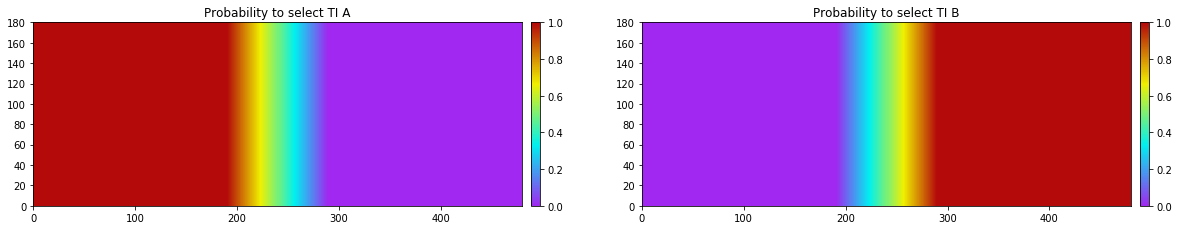

In [6]:
# Define images ('img.Img' class)
im = img.Img(nx, ny, nz, sx, sy, sz, ox, oy, oz, nv=2, val=pdf_ti)

# Display
plt.subplots(1,2, figsize=(20,5)) # 1 x 2 sub-plots

plt.subplot(1,2,1)
imgplt.drawImage2D(im, iv=0, title='Probability to select TI A')

plt.subplot(1,2,2)
imgplt.drawImage2D(im, iv=1, title='Probability to select TI B')

## Fill the input structure for deesse and launch deesse

In [7]:
deesse_input = dsi.DeesseInput(
    nx=nx, ny=ny, nz=nz,
    sx=sx, sy=sy, sz=sz,
    ox=ox, oy=oy, oz=oz,
    nv=1, varname='code',
    nTI=2, TI=[tiA, tiB],    # number of TIs, and list of TIs
    pdfTI=pdf_ti,            # set probability of TI selection
    distanceType=0,
    nneighboringNode=24,
    distanceThreshold=0.05,
    maxScanFraction=[0.25, 0.3],  # set maximal scanned fraction for each TI (list of length 'nTI')
    npostProcessingPathMax=1,
    seed=444,
    nrealization=1)

deesse_output = dsi.deesseRun(deesse_input)

********************************************************************************
DEESSE VERSION 3.2 / BUILD NUMBER 20200409
********************************************************************************
DONE


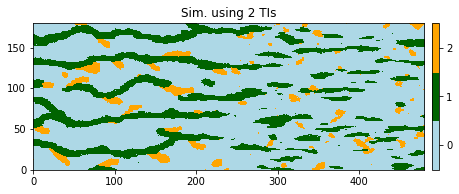

In [8]:
# Retrieve the results
sim = deesse_output['sim']

# Display
plt.figure(figsize=(16,5))

plt.subplot(1, 2, 2)
imgplt.drawImage2D(sim[0], categ=True, categCol=col, title='Sim. using 2 TIs')